In [1]:
%matplotlib inline
from IPython import display
from IPython.display import HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.distributions import Normal, Categorical

import numpy as np
import random
import os
import gym

In [2]:
# copy from Andrej karpathy's Policy Gradients for pong https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5
def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

In [2]:
def process_screen(screen):
  # corp
  # s = screen[35:195]
  # downscale
  screen = screen[::2,::2,::]
  # convert to greyscale
  screen = screen.dot([0.299,0.587,0.114])
  return screen

In [3]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

In [4]:
def save_torch_model(model, filename):
  if not os.path.exists(os.path.dirname(filename)):
    os.makedirs(os.path.dirname(filename))
  torch.save(model.state_dict(), filename)

def load_torch_model(model, filename):
  model.load_state_dict(torch.load(filename))

In [32]:
def plot(index, score, actor_loss, critic_loss):
    clear_output(True)
    plt.figure(figsize=(18,5))
    plt.subplot(131)
    plt.title('%d, score: %.2f' % (index, score[-1]))
    plt.plot(score)
    plt.subplot(132)
    plt.title('%d, actor_loss: %f' % (index, actor_loss[-1]))
    plt.plot(actor_loss)
    plt.subplot(133)
    plt.title('%d, critic_loss %f' % (index, critic_loss[-1]))
    plt.plot(critic_loss)
    plt.show()

In [33]:
class PolicyNet(nn.Module):
  def __init__(self, output_size):
    super(PolicyNet, self).__init__()
    self.l1_conv2d = nn.Conv2d(1, 16, kernel_size=5, stride=2)
    self.l1_bn = nn.BatchNorm2d(16)
    self.l2_conv2d = nn.Conv2d(16, 32, kernel_size=5, stride=2)
    self.l2_bn = nn.BatchNorm2d(32)
    self.l3_conv2d = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.l3_bn = nn.BatchNorm2d(32)
    self.l4_linear = nn.Linear(5440, 256)
    self.l5_linear = nn.Linear(256, output_size)
    self.l5_linear.weight.data.zero_()
    
  def forward(self,x):
    out = F.relu(self.l1_bn(self.l1_conv2d(x)))
    out = F.relu(self.l2_bn(self.l2_conv2d(out)))
    out = F.relu(self.l3_bn(self.l3_conv2d(out)))
    out = F.relu(self.l4_linear(out.view(out.size(0), -1)))
    out = self.l5_linear(out)
    out = F.softmax(out)
    return out

In [34]:
class ValueNet(nn.Module):
  def __init__(self):
    super(ValueNet, self).__init__()
    self.l1_conv2d = nn.Conv2d(1, 16, kernel_size=5, stride=2)
    self.l1_bn = nn.BatchNorm2d(16)
    self.l2_conv2d = nn.Conv2d(16, 32, kernel_size=5, stride=2)
    self.l2_bn = nn.BatchNorm2d(32)
    self.l3_conv2d = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.l3_bn = nn.BatchNorm2d(32)
    self.l4_linear = nn.Linear(5440, 256)
    self.l5_linear = nn.Linear(256, 1)
    self.l5_linear.weight.data.zero_()

    
  def forward(self,x):
    out = F.relu(self.l1_bn(self.l1_conv2d(x)))
    out = F.relu(self.l2_bn(self.l2_conv2d(out)))
    out = F.relu(self.l3_bn(self.l3_conv2d(out)))
    out = F.relu(self.l4_linear(out.view(out.size(0), -1)))
    out = self.l5_linear(out)
    return out

In [35]:
class PPO():
  def __init__(self, env):
    self.is_training = True
    self.actor = PolicyNet(env.action_space.n)
    self.actor_prime = PolicyNet(env.action_space.n)
    self.critic = ValueNet()
    if use_cuda:
      self.actor.cuda()
      self.actor_prime.cuda()
      self.critic.cuda()
    # copy the weight in actor, make sure actor and actor_prime start with same weights
    self.actor_prime.load_state_dict(self.actor.state_dict())
    self.env = env
    self._gamma = 0.97
    self._lambda = 1
    self._epsilon = 0.15

  def pick_action(self, state):
    action_dist = self.actor(state)
    # add noise
    if self.is_training:
      action_dist = Categorical(action_dist)
      action = action_dist.sample().item()
    else:
      action = torch.argmax(action_dist).item()
    return action
  
  def update_ppo_clip(self, batch):
    (states, actions, rewards, next_states, ended) = zip(*batch)
    states_tensor = torch.cat(states)
    actions_tensor = FloatTensor(actions).view(-1,1)
    rewards_tensor = FloatTensor(rewards).view(-1,1)
    next_states_tensor = torch.cat(next_states)
    ended_tensor = FloatTensor(ended).view(-1,1)
    
    critic_loss = rewards_tensor + self._gamma * (1 - ended_tensor) * self.critic(next_states_tensor) - self.critic(states_tensor)
    advantage = []
    for delta in critic_loss.view(-1).tolist()[::-1]:
      adv = delta
      if len(advantage) > 0:
        adv += self._gamma * self._lambda * advantage[0]
      advantage.insert(0, adv)
    advantage_tensor = FloatTensor(advantage).view(-1,1)
                             
    action_dist_prime = Categorical(self.actor_prime(states_tensor))
    action_dist_old = Categorical(self.actor(states_tensor))
    
    # Normal distribution class in Pytroch only provide a log_prob function.
    # so log_prob is used here then torch.exp covert it back to probability ratio. ln(a) - ln(b) = ln(a/b). e^ln(a/b) = a/b
    action_prob_ratio = torch.exp(action_dist_prime.log_prob(actions_tensor) - action_dist_old.log_prob(actions_tensor))
    actor_loss = torch.min(action_prob_ratio * advantage_tensor, \
                           torch.clamp(action_prob_ratio, 1 - self._epsilon, 1 + self._epsilon) * advantage_tensor)
    
    actor_loss = -actor_loss.mean()
    self.actor_prime_optimizer.zero_grad()
    actor_loss.backward(retain_graph=True)
    self.actor_prime_optimizer.step()

    # mean square of critic_loss
    critic_loss = critic_loss * critic_loss
    critic_loss = critic_loss.mean()
    self.critic_coptimizer.zero_grad()
    critic_loss.backward(retain_graph=True)
    self.critic_coptimizer.step()
    
    return (actor_loss.item(), critic_loss.item())
    
  def train(self, env, episode_limit=1000, batch_size=64, copy_on_episode=10, lr=1e-3, lr_actor=None, lr_critic=None, checkpoint=100):
    lr_actor = lr if lr_actor == None else lr_actor
    lr_critic = lr if lr_critic == None else lr_critic
    
    self.actor_prime_optimizer = torch.optim.Adam(self.actor_prime.parameters(), lr=lr_actor)
    self.critic_coptimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)
    
    best_score = -99999
    running_score = None
    running_actor_loss = None
    running_critic_loss = None
    graph = {'running_score':[], 'running_actor_loss':[], 'running_critic_loss':[]}
    self.iteration = 0
    self.update_count = 0
    for episode_count in range(episode_limit):
      s0 = env.reset()
      # skip first frame
      env.step(0)
      s0 = env.render(mode='rgb_array')
      s0 = process_screen(s0)
      state = FloatTensor(np.append(s0,s0,1)).unsqueeze(0).unsqueeze(0)
      episode_ended = False
      score = 0
      game_length = 0
      episode = []
      while not episode_ended:
        game_length += 1
        action = self.pick_action(state)
        (s1, reward, episode_ended, info) = env.step(action)
        s1 = process_screen(s1)
        next_state = FloatTensor(np.append(s0,s1,1)).unsqueeze(0).unsqueeze(0)
        if episode_ended:
          ended = 1
        else:
          ended = 0
        episode.append((state, action, reward, next_state, ended))
        s0 = s1
        state = next_state
        score += reward
        if len(episode) == batch_size or episode_ended:
          if (episode_ended):
            episode.pop()
          if len(episode) > 0:
            self.update_count += 1
            (actor_loss,critic_loss) = self.update_ppo_clip(episode)
            if running_actor_loss == None:
              running_actor_loss = actor_loss
              running_critic_loss = critic_loss
            else:
              running_actor_loss = running_actor_loss * 0.9 + actor_loss * 0.1
              running_critic_loss = running_critic_loss * 0.9 + critic_loss * 0.1
          episode = []

      if running_score == None:
        running_score = score
      else:
        running_score = running_score * 0.9 + score * 0.1
      print('%d: running_score:%.2f, score:%d, game_length:%d' %(episode_count+1, running_score, score, game_length))

      if (episode_count + 1) % 10 == 0:
        graph['running_score'].append(running_score)
        graph['running_actor_loss'].append(running_actor_loss)
        graph['running_critic_loss'].append(running_critic_loss)
        plot(episode_count + 1, graph['running_score'], graph['running_actor_loss'], graph['running_critic_loss'] )
      if (episode_count + 1) % checkpoint == 0 and running_score != None:
        if running_score > best_score:
          best_score = running_score
          save_torch_model(self.actor,'model/ppo_pong_actor_best.pth')          
          save_torch_model(self.actor,'model/ppo_pong_critic_best.pth')          
        save_torch_model(self.actor,'model/ppo_pong_actor_iter_%d.pth' %(episode_count+1))
        save_torch_model(self.actor,'model/ppo_pong_critic_iter_%d.pth' %(episode_count+1))
        save_torch_model(self.actor,'model/ppo_pong_actor_latest.pth')
        save_torch_model(self.actor,'model/ppo_pong_critic_latest.pth')

      if  (episode_count + 1) % copy_on_episode == 0:
        self.actor.load_state_dict(self.actor_prime.state_dict())


In [36]:
env = gym.make('Breakout-v0')
agent = PPO(env)

In [ ]:
agent.train(env, episode_limit=1, batch_size=1, copy_on_episode=1, lr_actor=1e-4, lr_critic=1e-3, checkpoint=50)

/Users/ju/anaconda2/envs/pytorch0.4/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1: running_score:0.00, score:0, game_length:189


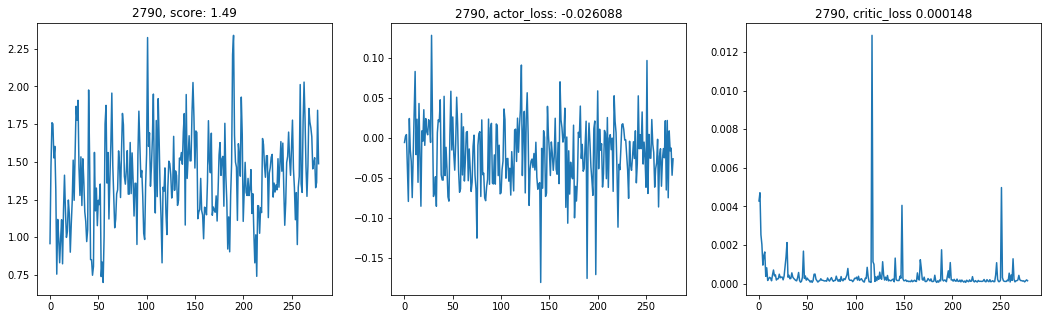

2791: running_score:1.64, score:3, game_length:287
2792: running_score:1.47, score:0, game_length:165
2793: running_score:1.43, score:1, game_length:204
2794: running_score:1.38, score:1, game_length:210
2795: running_score:1.25, score:0, game_length:176


In [ ]:
agent.train(env, episode_limit=100000, batch_size=64, copy_on_episode=1, lr_actor=1e-4, lr_critic=1e-3, checkpoint=50)

In [159]:
rgb_array = env.reset()
f = prepro(rgb_array)
t = screen_to_tensor(rgb_array)
print(rgb_array.shape)
print(t.shape)

(210, 160, 3)
torch.Size([1, 3, 105, 80])


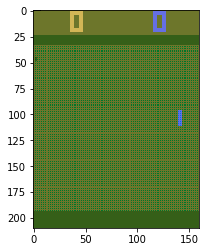

In [158]:
plt.imshow(rgb_array)

In [135]:
a2 = [rgb_array,rgb_array]
np.append(rgb_array,rgb_array)

TypeError: append() missing 1 required positional argument: 'values'

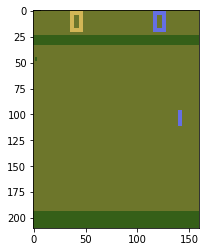

In [127]:
plt.imshow(rgb_array)

In [48]:
torch.argmax(FloatTensor([10,5,21])).item()

2

In [181]:
d = Categorical(FloatTensor([0.1,0.4,0.3,0.2]))

In [200]:
d.log_prob(LongTensor([0]))

tensor([-2.3026])

In [23]:
t = FloatTensor([0.1,0.4,0.5])

In [27]:
am = torch.argmax(t).item()

In [28]:
am

2